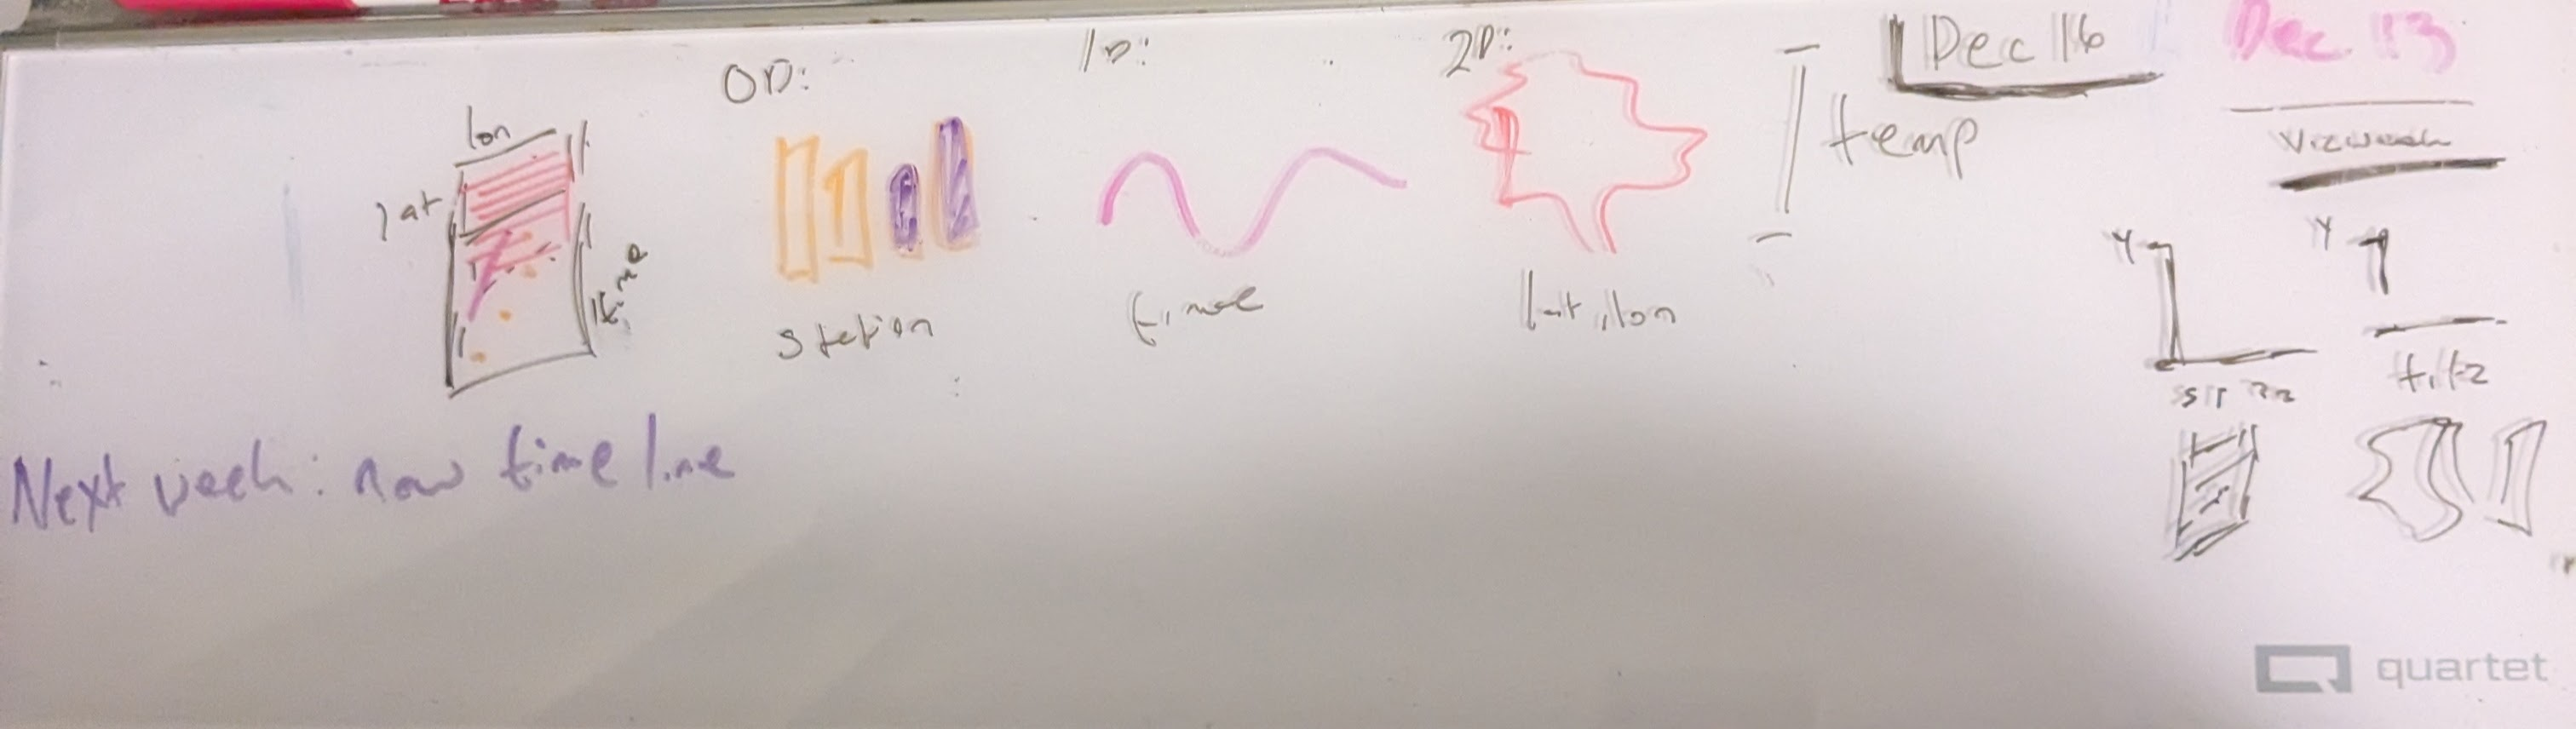

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.text as mtext
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import proj3d
import cmocean
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.transforms as mtransforms
import intro_plots as ip
import papercolors
from papercolors import colordict as pcd

mpl.rcParams['font.family'] = 'dejavu sans'
mpl.rcParams['figure.dpi'] = 200
fs={'normal': 10, 'small':9, 'footnote':8, 'script':7, 'tiny':5, 'heading':12}
paper_path = Path('../figures/')

In [2]:
import pandas as pd
import geopandas as gpd
import metpy
from metpy.interpolate import interpolate_to_grid
import numpy as np

In [3]:
# reshape data 

In [4]:
df = pd.read_parquet("nydata_2022.parquet")

In [5]:
df['NAME'].unique()

<StringArray>
[              'BINGHAMTON',             'LAGUARDIA AP',
       'ROCHESTER GTR INTL',    'ISLIP-LI MACARTHUR AP',
           'GLENS FALLS AP', 'SYRACUSE HANCOCK INTL AP',
              'JFK INTL AP',           'ALBANY INTL AP',
                  'BUFFALO']
Length: 9, dtype: string

In [6]:
df[df['NAME'].isin(['LAGUARDIA AP', 'JFK INTL AP', 'ALBANY INTL AP'])]

,ID,NAME,LATITUDE,LONGITUDE,DATE,TAVG,PRCP
1,USW00014732,LAGUARDIA AP,40.7794,-73.8803,20221120,36.86,0.000000
9,USW00094789,JFK INTL AP,40.6392,-73.7639,20221206,46.94,0.429133
13,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20221214,26.06,0.000000
16,USW00094789,JFK INTL AP,40.6392,-73.7639,20221223,45.32,0.299212
17,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20221223,38.12,1.590548
...,...,...,...,...,...,...,...
248,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20221012,55.22,0.000000
250,USW00094789,JFK INTL AP,40.6392,-73.7639,20221014,60.26,0.110236
255,USW00014732,LAGUARDIA AP,40.7794,-73.8803,20221018,54.68,0.000000
263,USW00014732,LAGUARDIA AP,40.7794,-73.8803,20221030,54.50,0.000000


In [7]:
dates = df['DATE'].sort_values().unique()
lons = df['LONGITUDE'].sort_values().unique()
lats = df['LATITUDE'].sort_values().unique()

i, j, k =  np.meshgrid(dates, lons, lats)

In [8]:
df['DATE_DTYPE'] = pd.to_datetime(df['DATE'])
prp = df[df['NAME'].isin(['LAGUARDIA AP', 'JFK INTL AP', 'ALBANY INTL AP']) & (df['DATE_DTYPE'].dt.month==3)].pivot_table(columns="NAME", index='DATE_DTYPE', values=
                                                                             'PRCP')
prp[(prp.values!=0).any(axis=1)]

NAME,ALBANY INTL AP,JFK INTL AP,LAGUARDIA AP
DATE_DTYPE,,,
2022-03-01,0.011811,0.000000,0.000000
2022-03-03,0.031496,0.078740,0.031496
2022-03-06,0.000000,0.051181,0.051181
2022-03-07,0.578739,0.059055,0.051181
2022-03-09,0.291338,0.610235,0.578739
2022-03-12,0.330708,0.499999,0.468503
2022-03-15,0.031496,0.000000,0.000000
2022-03-17,0.039370,0.059055,0.110236
2022-03-19,0.279527,0.181102,0.070866


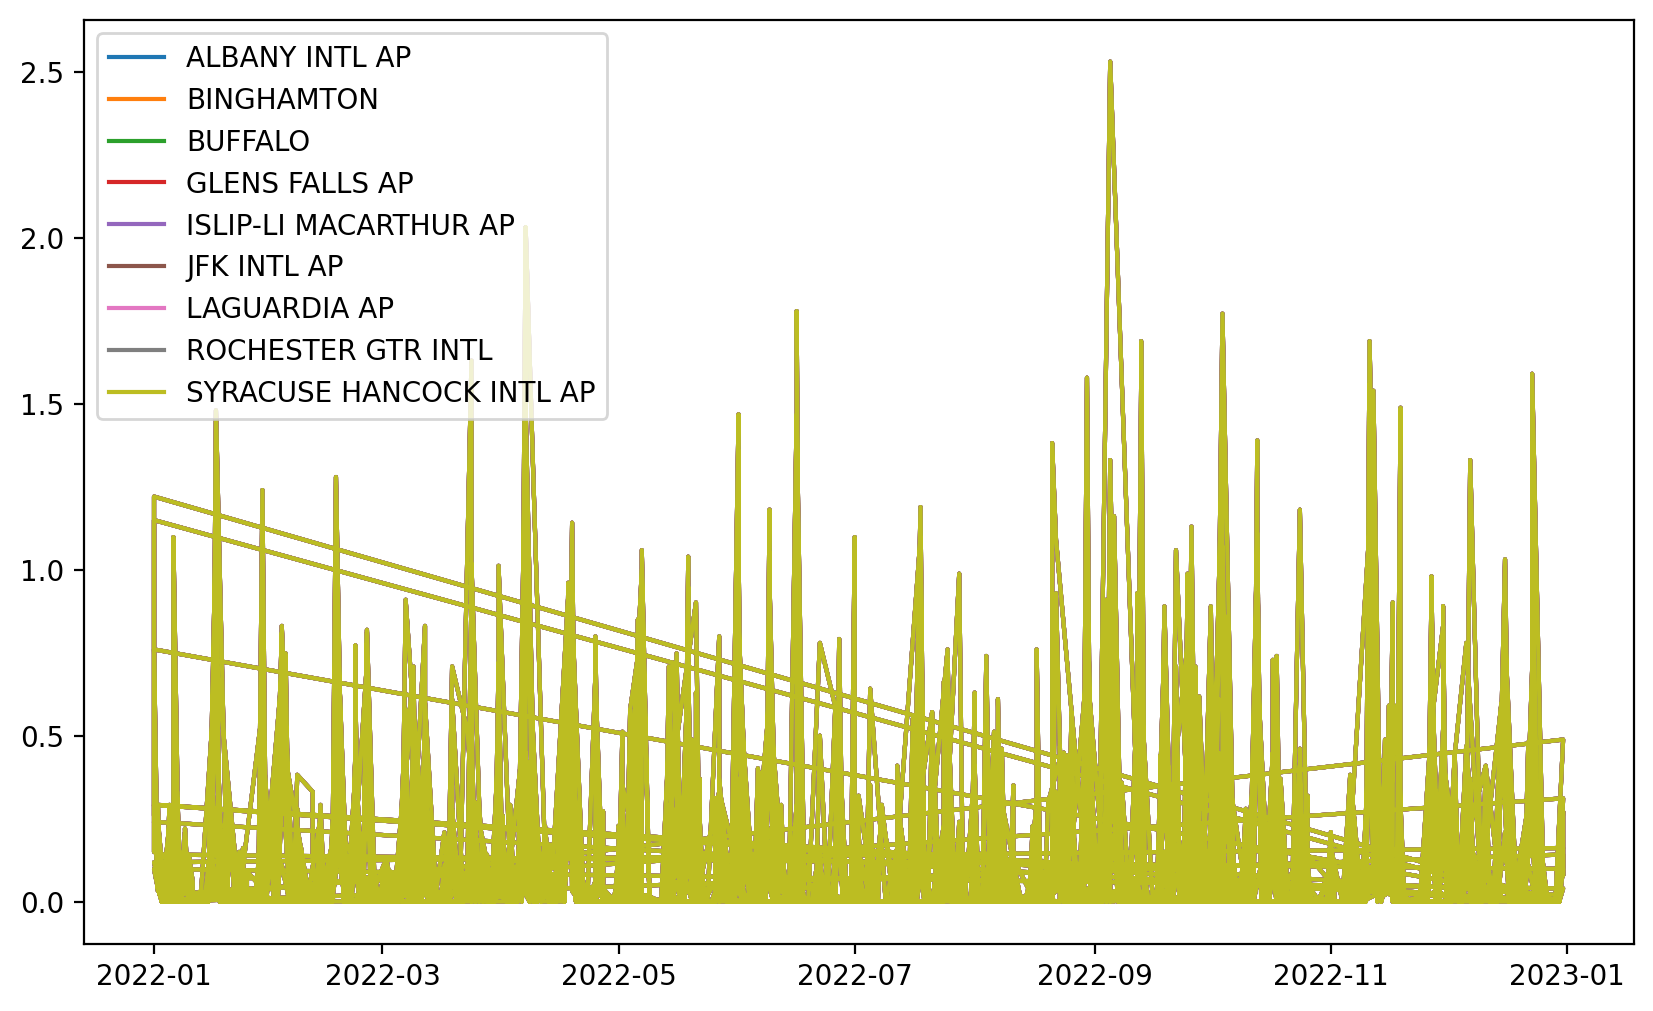

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
for name, gdf in df.sort_values(by='DATE').groupby('NAME'):
    ax.plot('DATE_DTYPE', 'PRCP', data=df, label=name)
ax.legend()

In [10]:
pdf = df.pivot(index='DATE_DTYPE', columns = 'NAME', values = 'PRCP')
dates[np.all(np.isfinite(pdf.values), axis=1) & np.all(pdf.values>.2, axis=1)]

<StringArray>
['20220117', '20220204', '20220225', '20220407', '20220418', '20220609',
 '20221013', '20221111', '20221127']
Length: 9, dtype: string

In [11]:
# random date
map_date = '20220609'
map_color = 'sienna' 
# albany
t_lon = -73.7992
t_lat = 42.7472
time_color = 'deepskyblue'

# jfk and lga

point_date = '20220309'
point_color = 'thistle'
jfk_lon = -73.7639
jfk_lat = 40.6392
jfk_color = 'steelblue'
lga_lon = -73.8803
lga_lat = 40.7794
lga_color = 'lightskyblue'

In [12]:
vox_shape = (lons.size, dates.size, lats.size)
filled = np.zeros(vox_shape, dtype='bool') 
colors = np.empty(vox_shape, dtype= object)
edgecolors = np.empty(vox_shape, dtype=object)

# plane: fixed time
mp = (i == map_date)
filled[mp] = 1
colors[mp] = map_color


# timeseries: fixed lat and lon 
time = (j == t_lon ) & (k == t_lat) 
filled[time] = 1
colors[time] = time_color
#edgecolors[lga] = lga_color
alb = ((i==point_date) & (j==t_lon) & (k == t_lat))
time_point_color =  mcolors.to_hex(papercolors.lighten(time_color, 2))
edgecolors[alb] = time_point_color
# points  - compare two stations
jfk = ((i==point_date) & (j==jfk_lon) & (k==jfk_lat))
filled[jfk] = 1
colors[jfk] = jfk_color
#edgecolors[jfk] = jfk_color
lga = ((i==point_date) & (j ==lga_lon) & (k == lga_lat))
filled[lga]= 1
colors[lga] = lga_color



In [13]:
x0, x1 = 0, len(lons)
y0, y1 = 0, len(dates)
z0, z1 = 0, len(lats)

#lon, date, fixed z
xy1 = [(x0, y0, z0), (x0, y1, z0),  (x1, y1, z0), (x1, y0, z0)]
xy2 = [(x0, y0, z1), (x0, y1, z1),  (x1, y1, z1), (x1, y0, z1),]
#lat, date, fixed x
yz1 = [(x0, y0, z0), (x0, y0, z1), (x0, y1, z1),  (x0, y1, z0)]
yz2 = [(x1, y0, z0), (x1, y0, z1), (x1, y1, z1),  (x1, y1, z0)]
# lon, lat, fixed y
xz1 = [(x0, y0, z0), (x0, y0, z1), (x1, y0, z1), (x1, y0, z0)]
xz2 = [(x0, y1, z0), (x0, y1, z1),(x1, y1, z1),  (x1, y1, z0)]

z_less = [xy1, xz2, yz1]
z_more = [xy2, xz1, yz2]

In [14]:
def make_cube(ax):
    cube_front = Poly3DCollection(z_more, facecolor=('lavender', .5), edgecolor=pcd['base'], ls=':', zorder=20)
    ax.add_collection3d(cube_front)
    
    vox = ax.voxels(filled, facecolors = colors, edgecolors=edgecolors, ls='--', shade=None, alpha=1, zorder=10)
    
    # project the date on the date axes so     
    y_ind = np.where(dates==point_date)[0]
    p_alpha = .75
    # y is the date, z is latitude +- where, longitude is lost, x is fixed at x0
    for p_lat, p_color in [(jfk_lat, jfk_color), (lga_lat, lga_color), (t_lat, time_point_color)]:
        p_ind = np.where(lats == p_lat)[0]
        ax.plot((x0, x0), (y_ind, y_ind), (p_ind, p_ind + 1), color=p_color, alpha=p_alpha)
    span_ind = np.where(lats == t_lat)[0]

    ax.plot((x0,x0), (y_ind, y_ind), (z0, x1), color=point_color, alpha=p_alpha, zorder=-1)

   
    
    N = 10
    t_ind = np.where(dates==map_date)
    poly_alpha = p_alpha - .25
    ax.fill_between(x0, np.linspace(y0, t_ind, N), span_ind, x0, np.linspace(y0, t_ind, N), span_ind+1, facecolor=time_color,  alpha=poly_alpha, edgecolor= None, zorder=-30)

    #fake the lines to get the correct zorder
    ax.plot((x0, x0),(y1, y1), (z0, z1), color=cube_front.get_ec(), ls=cube_front.get_ls()[0], zorder=-10, lw=cube_front.get_lw())
    ax.plot((x0, x0),(y0, y1), (z0, z0), color=cube_front.get_ec(), ls=cube_front.get_ls()[0], zorder=-10, lw=cube_front.get_lw())
    ax.plot((x0, x1),(y1, y1), (z0, z0), color=cube_front.get_ec(), ls=cube_front.get_ls()[0], zorder=-10, lw=cube_front.get_lw())
    ax.view_init(15, -50, None)
    ax.axis('off')
            

            
    ax.text(x0, y0+y1/2, z1, "date", zdir='y', va='bottom', ha='center', size=fs['normal'])
    ax.text(x1, y1, z0 + z1/2, "latitutude", zdir='z', ha='center', va='top', rotation=90, 
            transform_rotates_text=True, rotation_mode='anchor', size=fs['normal'])
    ax.text(x0+x1/2, y1, z1, "longitude", zdir='x', va='bottom', ha='center', size=fs['normal'] )
    return vox

In [15]:
ts = df[(df['LATITUDE'] == t_lat) & (df['LONGITUDE'] == t_lon)].sort_values(by='DATE')
ts['DATE_DTYPE'] = pd.to_datetime(ts['DATE'])

def make_ts(ax):
    ln,  = ax.plot('DATE_DTYPE', "PRCP", data=ts, color = time_color)
    ax.axvline(pd.to_datetime(point_date), color=point_color, alpha=.75, zorder=-1)
    ax.set_xlim(xmin=ts['DATE_DTYPE'].min(), xmax=ts['DATE_DTYPE'].max())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.annotate("2002", (1, -0.1), xycoords='axes fraction', 
                fontsize=fs['footnote'], va='top', ha='center')
    return ln 
    
def make_bars(ax1):
    ax1.set_title(pd.to_datetime(point_date).strftime(format="%b %d"), 
                  color=papercolors.lighten(point_color, 2), size=fs['small'])
    jfk = df[(df['DATE']==point_date) & (df['LATITUDE'] == jfk_lat) & (df['LONGITUDE'] == jfk_lon)]
    lga = df[(df['DATE']==point_date) & (df['LATITUDE'] == lga_lat) & (df['LONGITUDE'] == lga_lon)]
    bars = ax1.bar(["JFK", "LGA", "ALB"], [jfk['PRCP'].values[0], lga['PRCP'].values[0], ts[ts['DATE']==point_date]['PRCP'].values[0]], color=[jfk_color, lga_color, time_color])
    return bars

In [38]:
mdf = pd.read_csv("nydata.csv")
gdf = gpd.read_file('s_22mr22.zip')
nyshp = gdf[gdf['STATE'].str.match('NY')]
nyg = mdf[(mdf['DATE'].astype(str) == map_date)]
nygeo = gpd.GeoDataFrame(nyg, geometry=gpd.points_from_xy(nyg['LONGITUDE'], nyg['LATITUDE']), crs='EPSG:4269')

def make_map(ax):
    px, py, prcp = interpolate_to_grid(nygeo['LONGITUDE'].values, nygeo['LATITUDE'].values, nygeo['PRCPI'].values, 
                                       interp_type='barnes', minimum_neighbors=3, 
                                             search_radius=.25, hres=.025, gamma=1)
    cmap = cmocean.cm.rain
    norm = mcolors.Normalize(vmin=0, vmax=1)
    nyshp.plot(ax=ax,  facecolor='#f6f5f7' , edgecolor='none')
    im = ax.pcolormesh(px, py, prcp, cmap=cmap, norm=norm, alpha=.8)
    mp = nyshp.plot(ax=ax,  facecolor='none', edgecolor=map_color)
    for p_id, p_color in [('JFK INTL AP', jfk_color), ('LAGUARDIA AP', lga_color), ('ALBANY INTL AP', time_color)]:
        nygeo[nygeo['NAME']==p_id].plot(marker ='s',edgecolor=p_color, facecolor='none', ax=ax, markersize=60, lw=2)
    cb = fig.colorbar(im, ax=ax, fraction=.1, aspect=15, 
                      location='left', extend='max', pad=.001)
    cb.ax.tick_params(labelsize=fs['script'], length=0, pad=2)
    cb.ax.xaxis.set_major_formatter("{:0.2f} in.".format)
    ax.axis('off')
    
    ax.annotate(pd.to_datetime(map_date).strftime("%b %d"), (0.05,1), xycoords= mp, 
                color=map_color, fontsize=fs['small'], ha='left', va='top')
    
    return mp, im

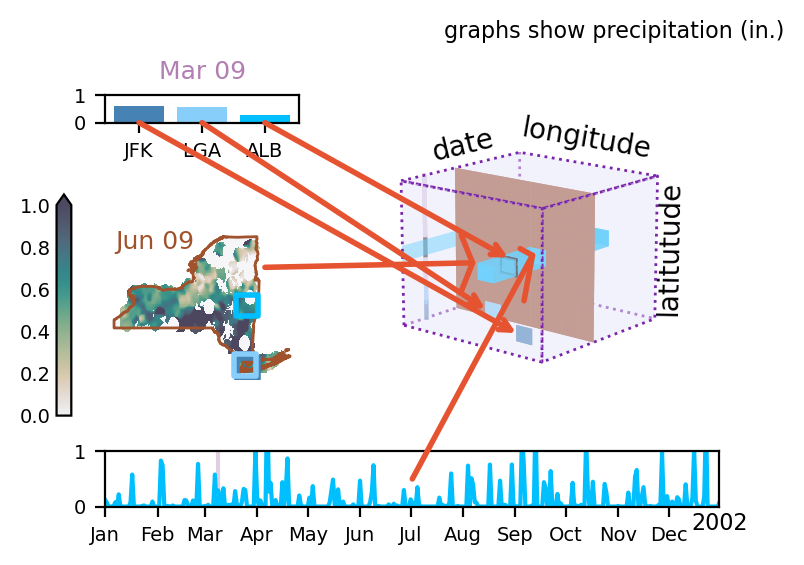

In [39]:
# draw shaded time stamps to mark time on zy plane
fig, axd = plt.subplot_mosaic([[ "bar", "cube"],
                              ["map", "cube"], 
                              ["ts", "ts"]], per_subplot_kw={"cube":{"projection":'3d'}}, 
                              layout='compressed', height_ratios=[1,8,2],
                              width_ratios = [1,2], figsize=(4,3))
vox = make_cube(axd['cube'])
ln = make_ts(axd['ts'])
bars = make_bars(axd["bar"])
mp, im = make_map(axd['map'])
fig.suptitle("graphs show precipitation (in.)", size=fs['footnote'], x=1, ha='right')
axd['bar'].set_ylim(0, 1)
axd['ts'].set_ylim(0, 1)

# bar to coordinates
# x = longitude, y=time, z = latitude 
y = np.where(dates==point_date)[0][0]

for i, (station, lon, lat) in enumerate([("JFK", jfk_lon, jfk_lat), ("LGA", lga_lon, lga_lat), ("ALB", t_lon, t_lat)]):
    x = np.where(lons == lon)[0][0]
    z = np.where(lats == lat)[0][0]
    if i < 2:
        xadj = x
        yadj = y
        zadj = z+.5
    else:
        xadj = x+.5
        yadj = y
        zadj = z+1
    xrp, yrp, _ = proj3d.proj_transform(xadj, yadj, zadj, axd['cube'].get_proj())
    arr= mpatches.ConnectionPatch(xyA=(station, 0), xyB=(xrp, yrp), 
                                    coordsA='data', coordsB="data",
                                    axesA=axd['bar'], axesB=axd['cube'],
                                    arrowstyle ='->', color=pcd['functor'], lw=2)
    fig.add_artist(arr)
# map to plane

y = np.where(dates==map_date)[0][0]
xrp, yrp, _ =  proj3d.proj_transform(3, y-65, lats.size//2, axd['cube'].get_proj())
arr_map = mpatches.ConnectionPatch(xyA=(.825,.75), xyB=(xrp, yrp), 
                                   coordsA='axes fraction', coordsB="data", 
                                   axesA=axd['map'], axesB=axd['cube'], 
                                   arrowstyle='->', color=pcd['functor'], lw=2, mutation_aspect = 5)
fig.add_artist(arr_map)
                                   

y = dates.size//2 + 2
x = np.where(lons==t_lon)[0][0]
z = np.where(lats==t_lat)[0][0] + 1

xrp, yrp, _ =  proj3d.proj_transform(x, y, z, axd['cube'].get_proj())
#trans = mtransforms.blended_transform_factory(axd['ts'].transAxes, axd['ts'].transData)
arr_time = mpatches.ConnectionPatch(xyA=(.5, .5), xyB=(xrp,yrp), 
                                   coordsA="axes fraction", coordsB="data", 
                                   axesA=axd['ts'], axesB=axd['cube'], 
                                   arrowstyle='->', color=pcd['functor'], lw=2, mutation_aspect = 5)
fig.add_artist(arr_time)

for axn in ['ts', 'bar', 'map']:
    axd[axn].tick_params(labelsize=fs['script'])
fig.savefig(paper_path/"k_different_types.pdf", dpi=300, bbox_inches='tight')